In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import time

import numpy as np

import torch
import torch.nn.functional as F

import cv2

import matplotlib.pyplot as plt

from viz_svls import LS, SVLS
from datasets import get_datasets_brats

In [4]:
DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats(data_root=DATA_PATH)

In [5]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

In [6]:
sample_idx = 12
depth = 60

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()
print(image.shape)
print(label.shape)

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

# print(label_oh.shape)
# print(label_ls.shape)
# print(label_svls.shape)

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()

# print(label_slice_oh.shape)
# print(label_slice_ls.shape)
# print(label_slice_svls.shape)

image_slice = image[:, depth, ...].cpu().numpy()

torch.Size([4, 128, 192, 192])
torch.Size([1, 128, 192, 192])


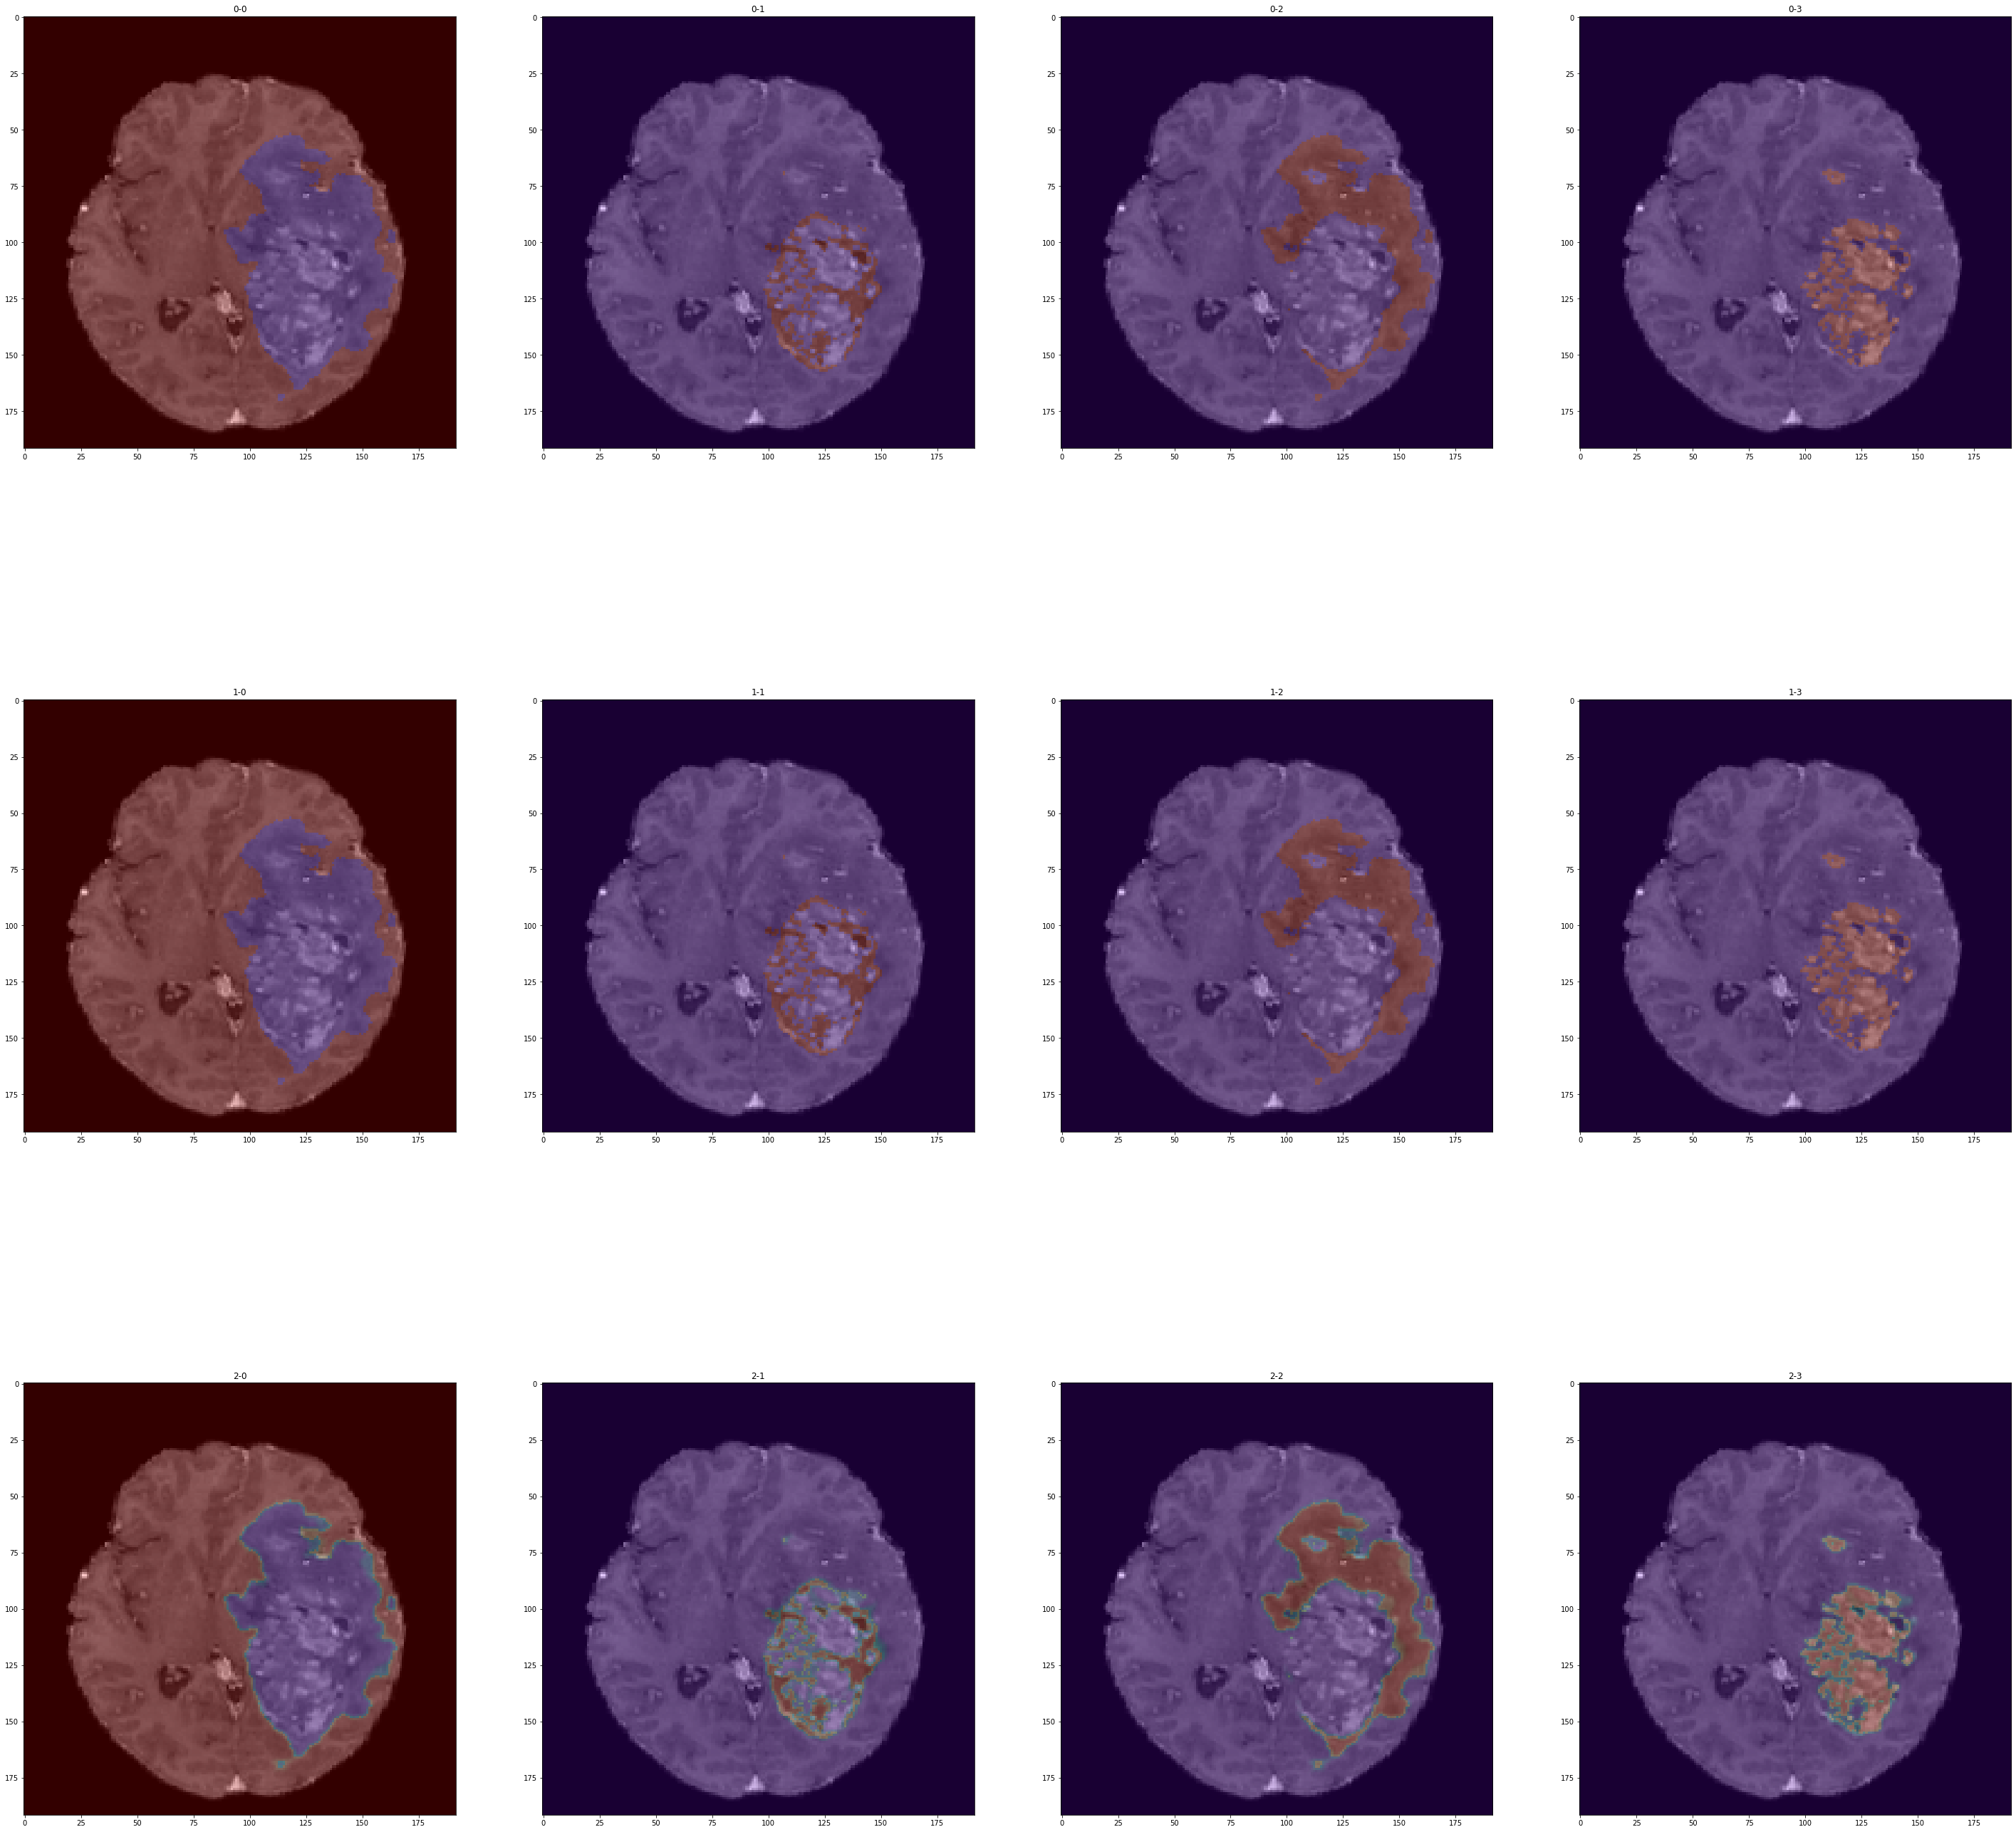

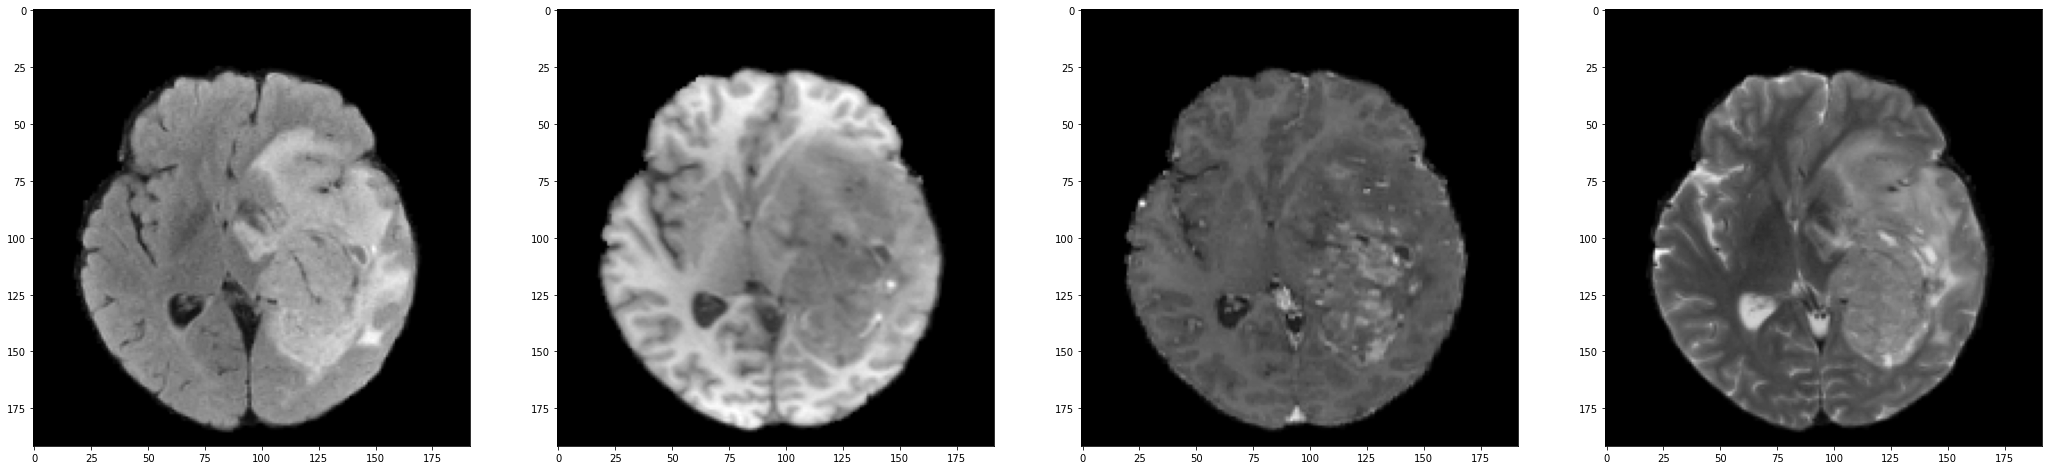

In [6]:
figure, axs = plt.subplots(3, 4, figsize=(50, 50))

_slices = [label_slice_oh, label_slice_ls, label_slice_svls]

for _type in range(3):
    _slice = _slices[_type]
    for _class in range(4):
        # print(f'{_type}-{_class}')
        # print(np.unique(_slice[_class+1]))
        axs[_type, _class].imshow(_slice[_class], cmap='rainbow')
        axs[_type, _class].imshow(image_slice[2], alpha=0.8, cmap='gray')
        axs[_type, _class].set_title(f'{_type}-{_class}')
plt.show()

figure, axs = plt.subplots(1, 4, figsize=(36, 36))
for seq in range(4):
    axs[seq].imshow(image_slice[seq], cmap='gray')
plt.show()

In [7]:
image_slice.shape

(4, 192, 192)

#### Generate a ball, and check what it looks like after LS and SVLS

In [8]:
def generate_mask(img_height=128,img_width=128,img_depth=128,radius=10,center_x=64,center_y=64,center_z=64):
 
    x = np.array(list(range(img_height))).reshape([img_height,1,1])
 
    y = np.array(list(range(img_width))).reshape([1,img_width,1])
 
    z = np.array(list(range(img_depth))).reshape([1,1,img_depth])
 
    # circle mask
 
    mask = (x-center_x)**2+(y-center_y)**2+(z-center_z)**2<=radius**2  
 
    return mask

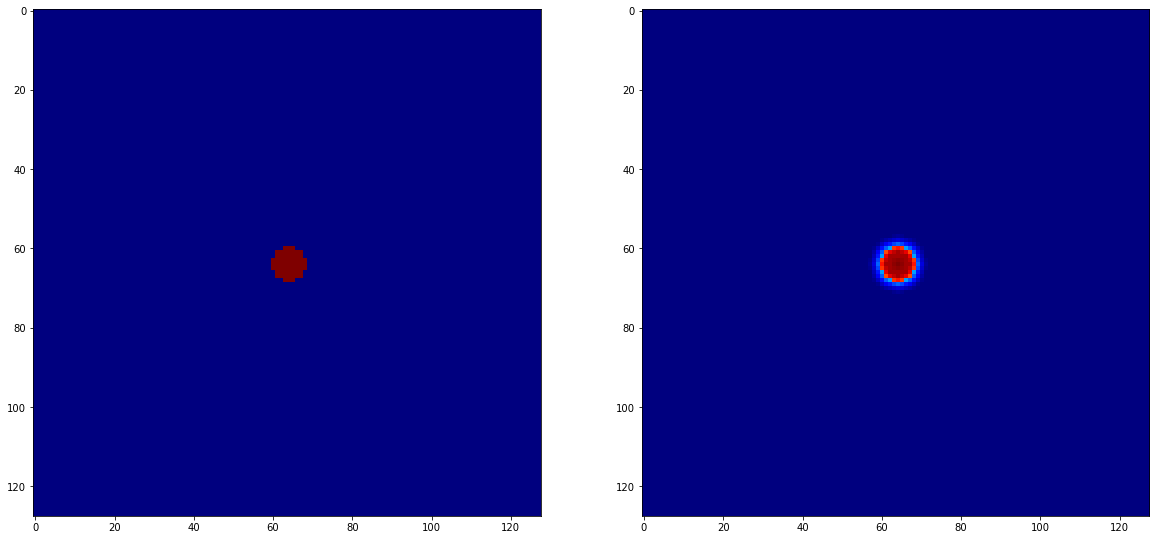

In [9]:
ball = generate_mask()

depth = 73

ball_slice = ball[depth, :, :]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(ball_slice, cmap='jet')

tensor_ball = torch.from_numpy(ball[None, ...]).cuda()
# svls_test = SVLS(4, 1.0).cuda()
tensor_ball_svls = svls(tensor_ball)
ball_svls_slice = tensor_ball_svls[0, :, depth, ...].cpu().numpy()

axs[1].imshow(ball_svls_slice[1], cmap='jet')

#### Generate three balls, and see what will happen after LS and SVLS

(128, 128)
(4, 128, 128)


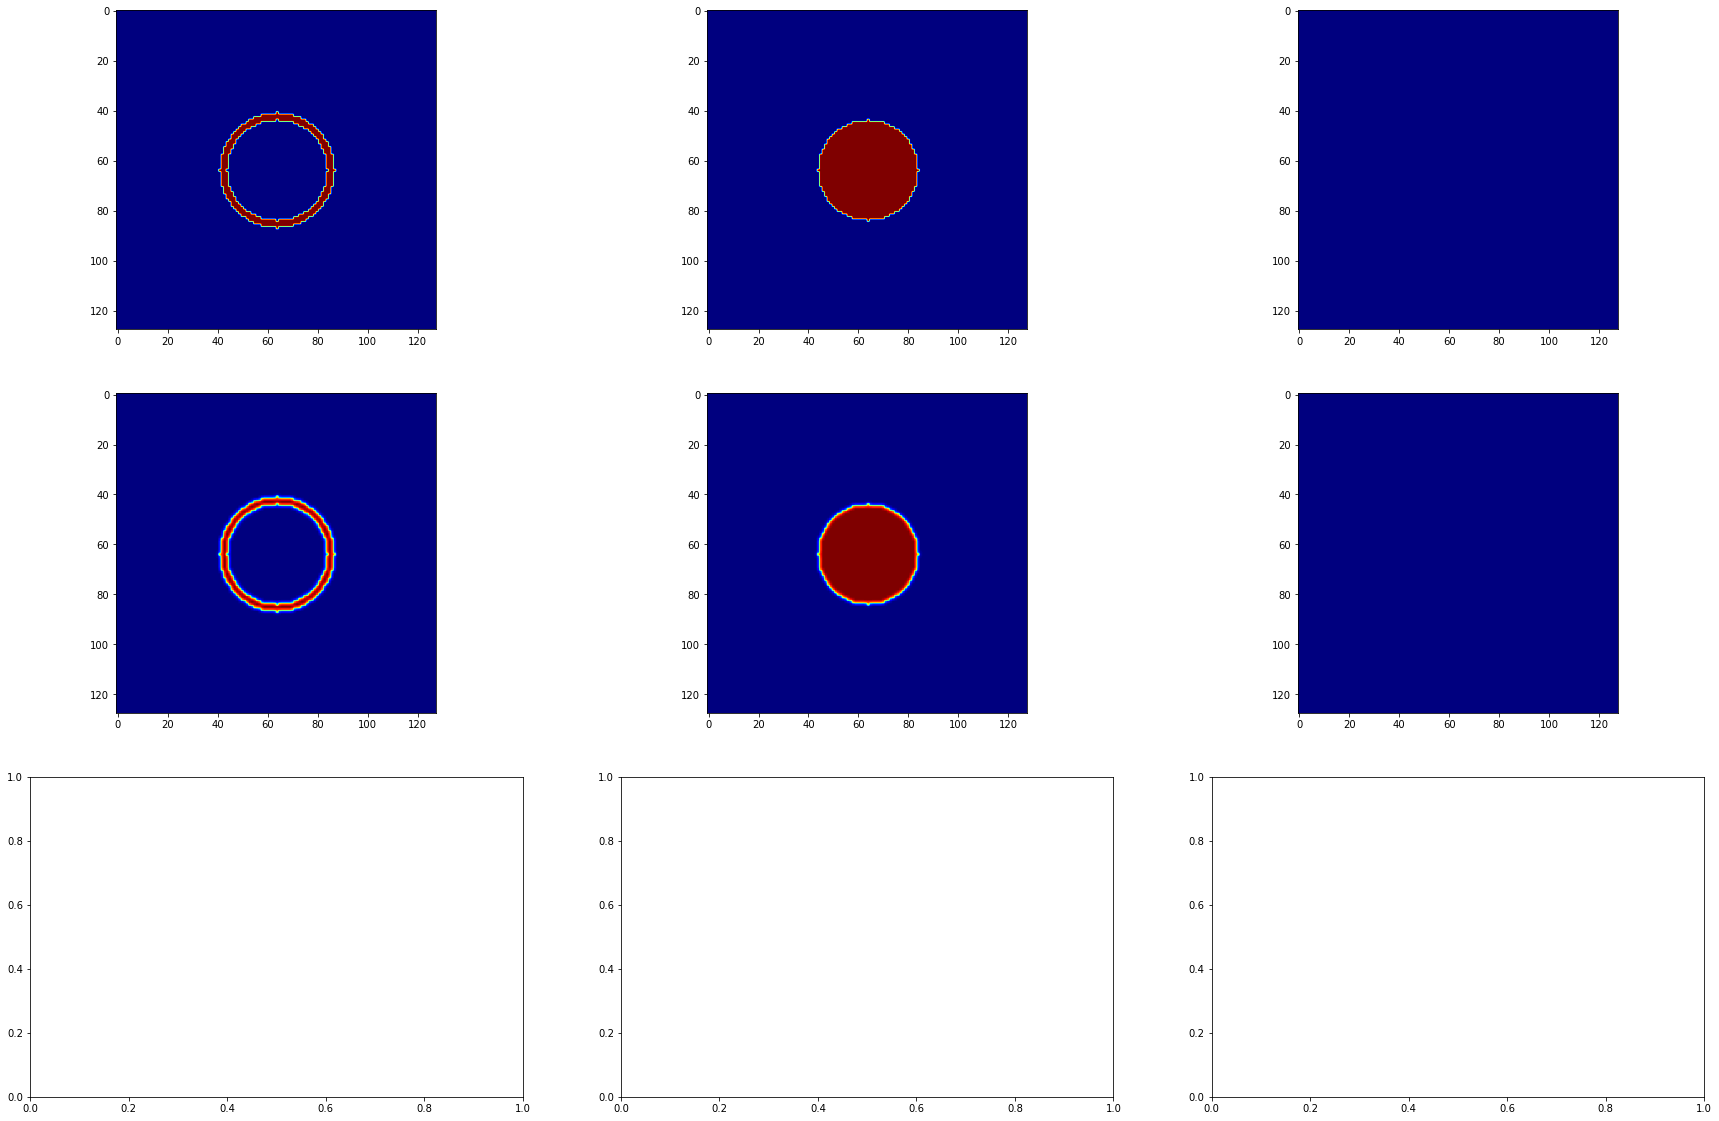

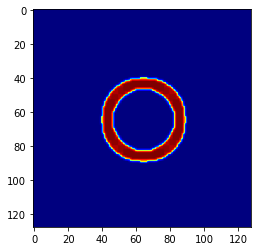

In [10]:
ball_one = generate_mask(radius=20).astype(np.uint8)
ball_two = generate_mask(radius=23).astype(np.uint8)
ball_three = generate_mask(center_z=90).astype(np.uint8) * 0

ball = ball_one + ball_two + ball_three

# ball.shape

# print(np.unique(ball))

depth = 64

fig, axs = plt.subplots(3, 3, figsize=(30, 20))

# one hot
ball_slice = ball[depth, :, :]

print(ball_slice.shape)

axs[0, 0].imshow((ball_slice==1).astype(np.float32), cmap='jet')
axs[0, 1].imshow((ball_slice==2).astype(np.float32), cmap='jet')
axs[0, 2].imshow((ball_slice==3).astype(np.float32), cmap='jet')

# SVLS
tensor_ball = torch.from_numpy(ball[None, ...]).cuda()
tensor_ball_svls = svls(tensor_ball)
ball_svls_slice = tensor_ball_svls[0, :, depth, ...].cpu().numpy()

print(ball_svls_slice.shape)
# print(np.unique(ball_svls_slice))

axs[1, 0].imshow(ball_svls_slice[1], cmap='jet')
axs[1, 1].imshow(ball_svls_slice[2], cmap='jet')
axs[1, 2].imshow(ball_svls_slice[3], cmap='jet')

kernel_2 = np.ones((4, 4), dtype=np.uint8) # 卷积核变为4*4
dilate = cv2.dilate(ball_svls_slice[1], kernel_2, 1)
plt.figure()
plt.imshow(dilate, cmap='jet')

In [11]:
dis = [-3, -2, -1, 0, 1, 2, 3, 4, 5]

for dis_ in dis:
    q = 0.5 * (dis_ / (1 + abs(dis_)) + 1)
    print(q)

0.125
0.16666666666666669
0.25
0.5
0.75
0.8333333333333333
0.875
0.9
0.9166666666666667


##### 实验 使用SLIC对体数据产生superpixel

In [12]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

img = item['image'].numpy()

img = img

print(img.shape)

# Compute a mask
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        img[0] > 0, 500),
    500)

# print(mask.shape)

tik = time.time()

mask = morphology.opening(mask, morphology.ball(11))

mask = np.repeat(mask[None, ...], axis=0, repeats=4)

print(mask.shape)

# # SLIC result
# slic = segmentation.slic(img, n_segments=300, compactness=0.1, start_label=1, channel_axis=None)

# print(time.time() - tik)

# # maskSLIC result
# m_slic = segmentation.slic(img, n_segments=100, compactness=0.08, mask=mask, start_label=1, channel_axis=None)

# print(time.time() - tik)

(4, 128, 192, 192)
(4, 128, 192, 192)


In [13]:
label = item['label']
label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))[0]
label_oh = label_oh.numpy()

label_oh.shape

(4, 128, 192, 192)

In [14]:
depth = 50

img_slice = img[depth]
slic_slice = slic[depth]
m_slic_slice = m_slic[depth]
mask_slice = mask[depth]
label_oh_slice = label_oh[3, depth, ...]

# Display result
fig, ax_arr = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = ax_arr.ravel()

ax1.imshow(img_slice, cmap='gray')
ax1.set_title('Original image')

ax2.imshow(mask_slice, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img_slice, slic_slice))
# ax3.imshow(label_oh_slice, cmap='jet', alpha=0.3)
ax3.contour(label_oh_slice, colors='blue', linewidths=1)
ax3.contour(mask_slice, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img_slice, m_slic_slice))
# ax4.imshow(label_oh_slice, cmap='jet', alpha=0.3)
ax4.contour(label_oh_slice, colors='blue', linewidths=1)
ax4.contour(mask_slice, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

ax5.imshow(segmentation.mark_boundaries(img_slice, slic_slice))
ax5.set_title('SLIC')

ax6.imshow(segmentation.mark_boundaries(img_slice, m_slic_slice))
ax6.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

IndexError: index 50 is out of bounds for axis 0 with size 4

In [16]:
import skimage

skimage.__version__

'0.19.1'

##### 实验 计算得到最近距离地形图

最近距离的定义：
- 到轮廓的最近距离
- 到骨架的最近距离
- 到体积质心的距离 不行，如果存在折返的情况，由此的到的距离可能不能反应voxel是否在核心
- 带通滤波？？


方法一：到轮廓的最近距离

In [135]:
label = item['label']

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))[0].numpy()

label_oh.shape

(4, 128, 192, 192)

In [136]:
label_oh_one_class = label_oh[2]

label_oh_one_class.shape

(128, 192, 192)

In [137]:
from skimage import morphology

# 处理得到边界
# label_oh_one_class_erosion = morphology.erosion(label_oh_one_class, morphology.octahedron(1))
label_oh_one_class_dilation = morphology.dilation(label_oh_one_class, morphology.octahedron(1))
# surface = label_oh_one_class - label_oh_one_class_erosion
surface = label_oh_one_class_dilation - label_oh_one_class

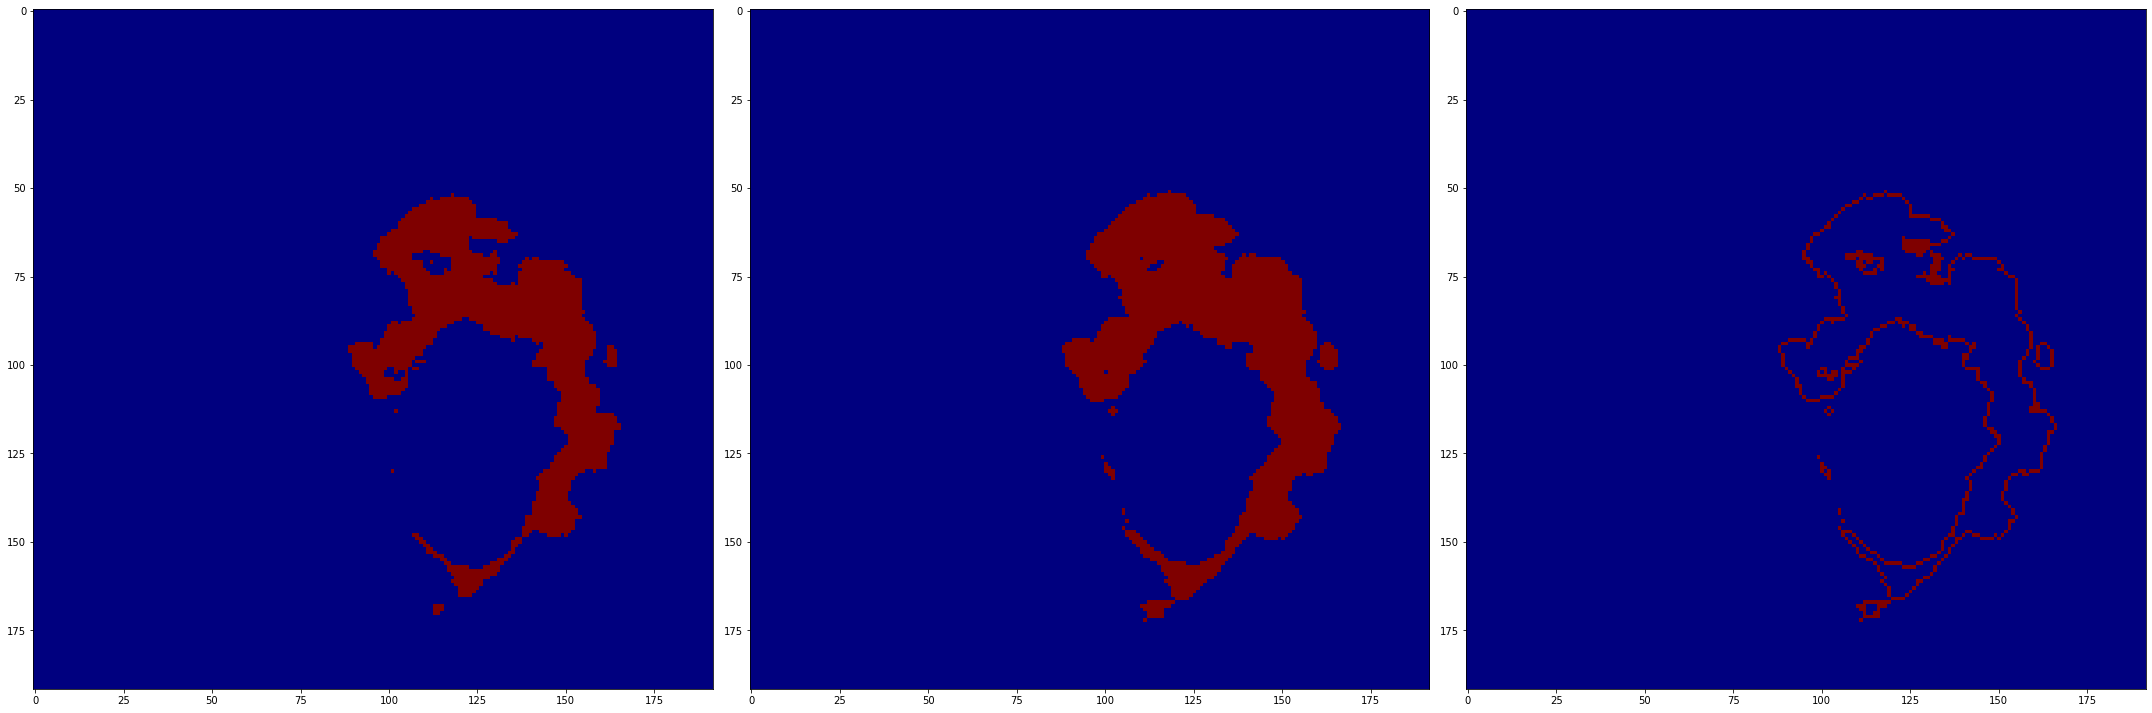

In [139]:
depth = 60

label_oh_one_class_slice = label_oh_one_class[depth]
# label_oh_one_class_erosion_slice = label_oh_one_class_erosion[depth]
label_oh_one_class_dilation_slice = label_oh_one_class_dilation[depth]
surface_slice = surface[depth]

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

ax1, ax2, ax3 = axs

ax1.imshow(label_oh_one_class_slice, cmap='jet')
# ax2.imshow(label_oh_one_class_erosion_slice, cmap='jet')
ax2.imshow(label_oh_one_class_dilation_slice, cmap='jet')
ax3.imshow(surface_slice, cmap='jet')

plt.tight_layout()
plt.show()

In [140]:
# 分别得到所有点和surface点的坐标集合
coords_label = np.array(np.where(label_oh_one_class)).T
coords_surface = np.array(np.where(surface)).T

from scipy.spatial.distance import cdist

# 计算点对(内部点和表面点)之间的距离
dist = cdist(coords_label, coords_surface, metric='euclidean')  

In [141]:
# 得到每个内部点到表面的最近距离
min_dist = np.min(dist, axis=1)

In [142]:
np.min(min_dist)

1.0

In [33]:
# min_dist_90 = np.percentile(min_dist, 50)

# print(min_dist_90)

# plt.figure()
# plt.plot(np.sort(min_dist))
# plt.show()

In [175]:
# 将最短距离映射回体数据
x, y, z = zip(*coords_label)

min_dist_label = np.zeros_like(label_oh_one_class) * 1.0
min_dist_label[x, y, z] = min_dist

In [164]:
np.min(min_dist_label)

0.0

In [176]:
print(np.max(min_dist_label))

# 归一化，控制范围为 [0, 1]
min_dist_label = min_dist_label / np.max(min_dist_label)

min_dist_label_slice = min_dist_label[depth]

print(np.max(min_dist_label))

10.488088481701515
1.0


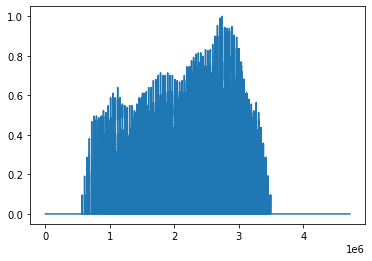

0.0


In [177]:
plt.figure()
plt.plot(min_dist_label.flatten())
plt.show()

print(np.min(min_dist_label))

In [181]:
# 我们希望得到一个局部意义上的相对距离度量
from skimage.filters.rank import maximum

# 取局部极大值，仅在具有合法min_dist的voxel处保留
local_maxima =  maximum(min_dist_label, morphology.ball(7)) / 255.  # 输出0-255!
local_maxima = np.where(min_dist_label > 0, local_maxima + 1e-6, np.ones_like(min_dist_label) * 1e-6)

local_maxima_slice = local_maxima[depth]

print(np.min(local_maxima))
print(np.max(local_maxima))

1e-06
1.000001


In [182]:
# 除以局部极大值，获得相对min_dist
relative_min_dist_label = np.where(min_dist_label > 0, min_dist_label / local_maxima, min_dist_label)  # 'relative'
relative_min_dist_label_slice = relative_min_dist_label[depth]

print(np.max(relative_min_dist_label))
print(np.min(relative_min_dist_label))

1.0130432374890437
0.0


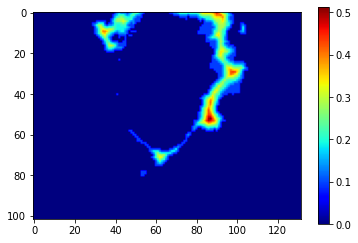

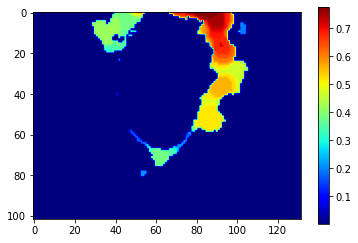

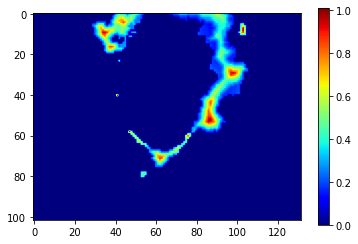

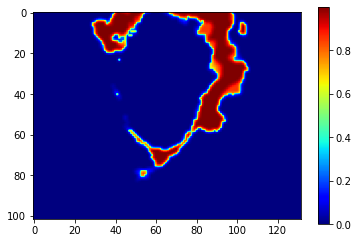

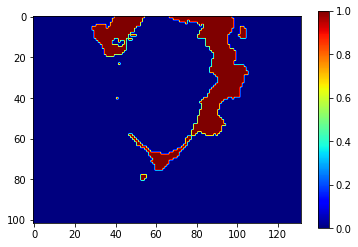

In [183]:
plt.figure()
plt.imshow(min_dist_label_slice[90:, 60:], cmap='jet')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(local_maxima_slice[90:, 60:], cmap='jet')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(relative_min_dist_label_slice[90:, 60:], cmap='jet')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(label_slice_svls[2][90:, 60:], cmap='jet')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(label_oh_one_class_slice[90:, 60:], cmap='jet')
plt.colorbar()
plt.show()

In [76]:
label_slice_svls.shape

(4, 192, 192)

##### 方法2：基于形态学骨架的方法
如何获取骨架？


In [7]:
label = item['label']

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))[0].numpy()

label_oh.shape

(4, 128, 192, 192)

In [8]:
label_oh_one_class = label_oh[2]

label_oh_one_class.shape

(128, 192, 192)

##### 获取distance map

In [15]:
from scipy.ndimage import distance_transform_edt

In [16]:
label_oh_one_class_distance = distance_transform_edt(label_oh_one_class)
label_oh_one_class_distance_slice = label_oh_one_class_distance[depth]

label_oh_one_class_slice = label_oh_one_class[depth]

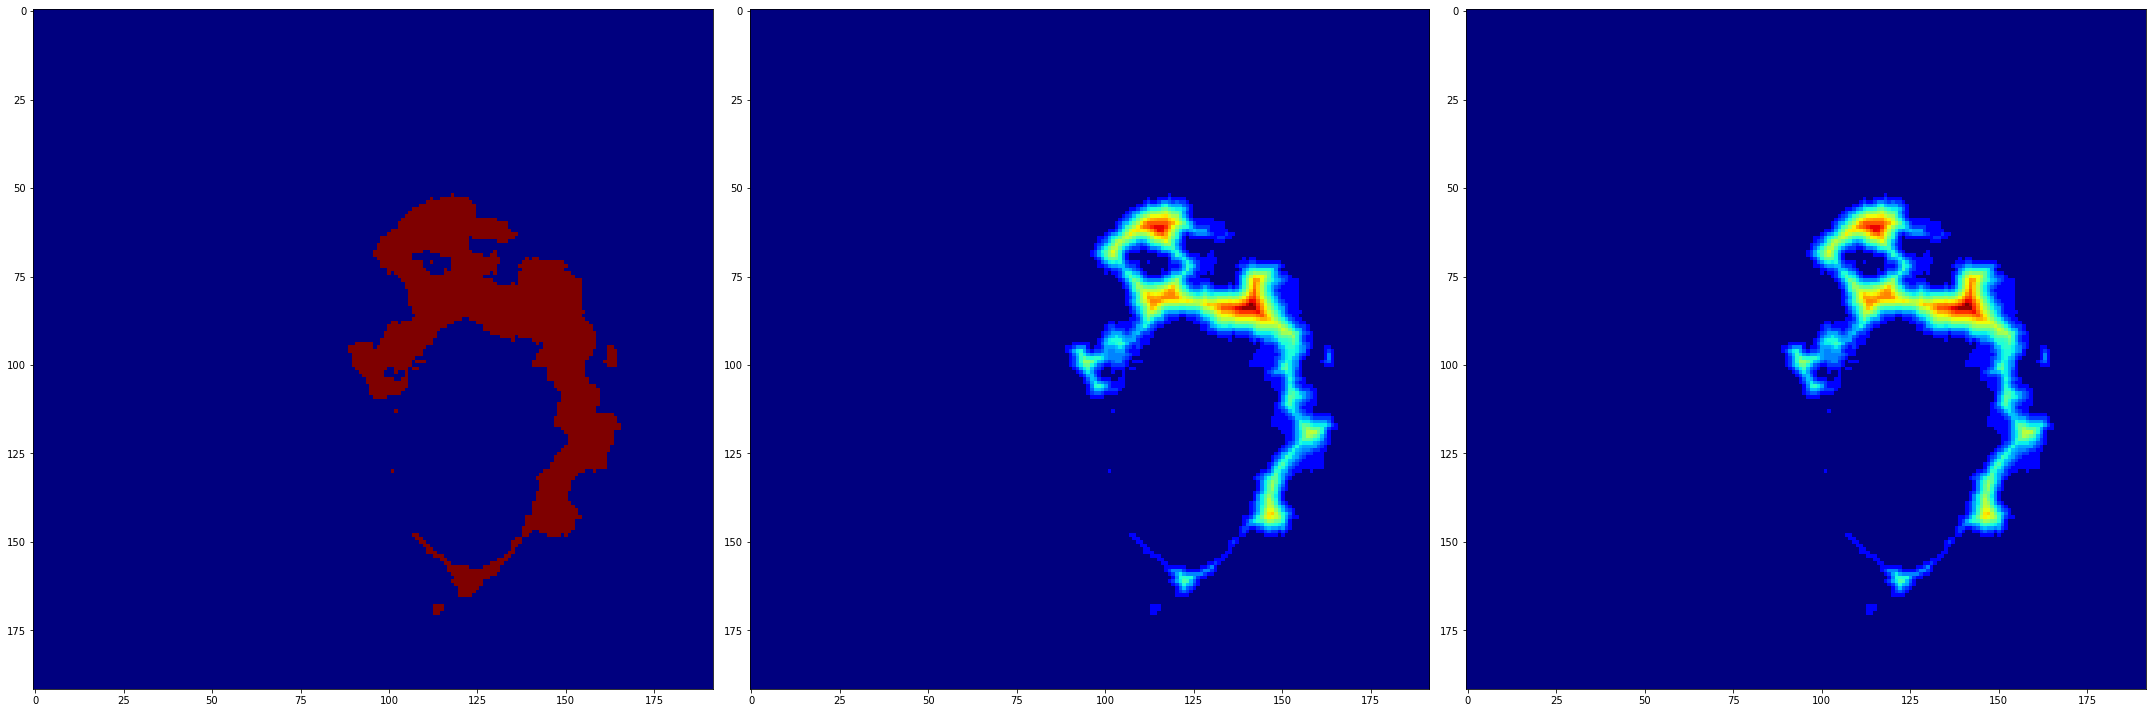

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

ax1, ax2, ax3 = axs

ax1.imshow(label_oh_one_class_slice, cmap='jet')
ax2.imshow(label_oh_one_class_distance_slice, cmap='jet')
ax3.imshow(label_oh_one_class_distance_slice, cmap='jet')

plt.tight_layout()
plt.show()

##### 获取骨架

In [6]:
from skimage import morphology

In [19]:
label_oh_one_class_slice = label_oh_one_class[depth]

label_oh_one_class_skeleton = morphology.skeletonize(label_oh_one_class)
label_oh_one_class_skeleton_slice = label_oh_one_class_skeleton[depth]
label_oh_one_class_skeleton_dilation = morphology.dilation(label_oh_one_class_skeleton)
label_oh_one_class_skeleton_dilation_slice = label_oh_one_class_skeleton_dilation[depth]

/home/s2018013343/anaconda3/lib/python3.8/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


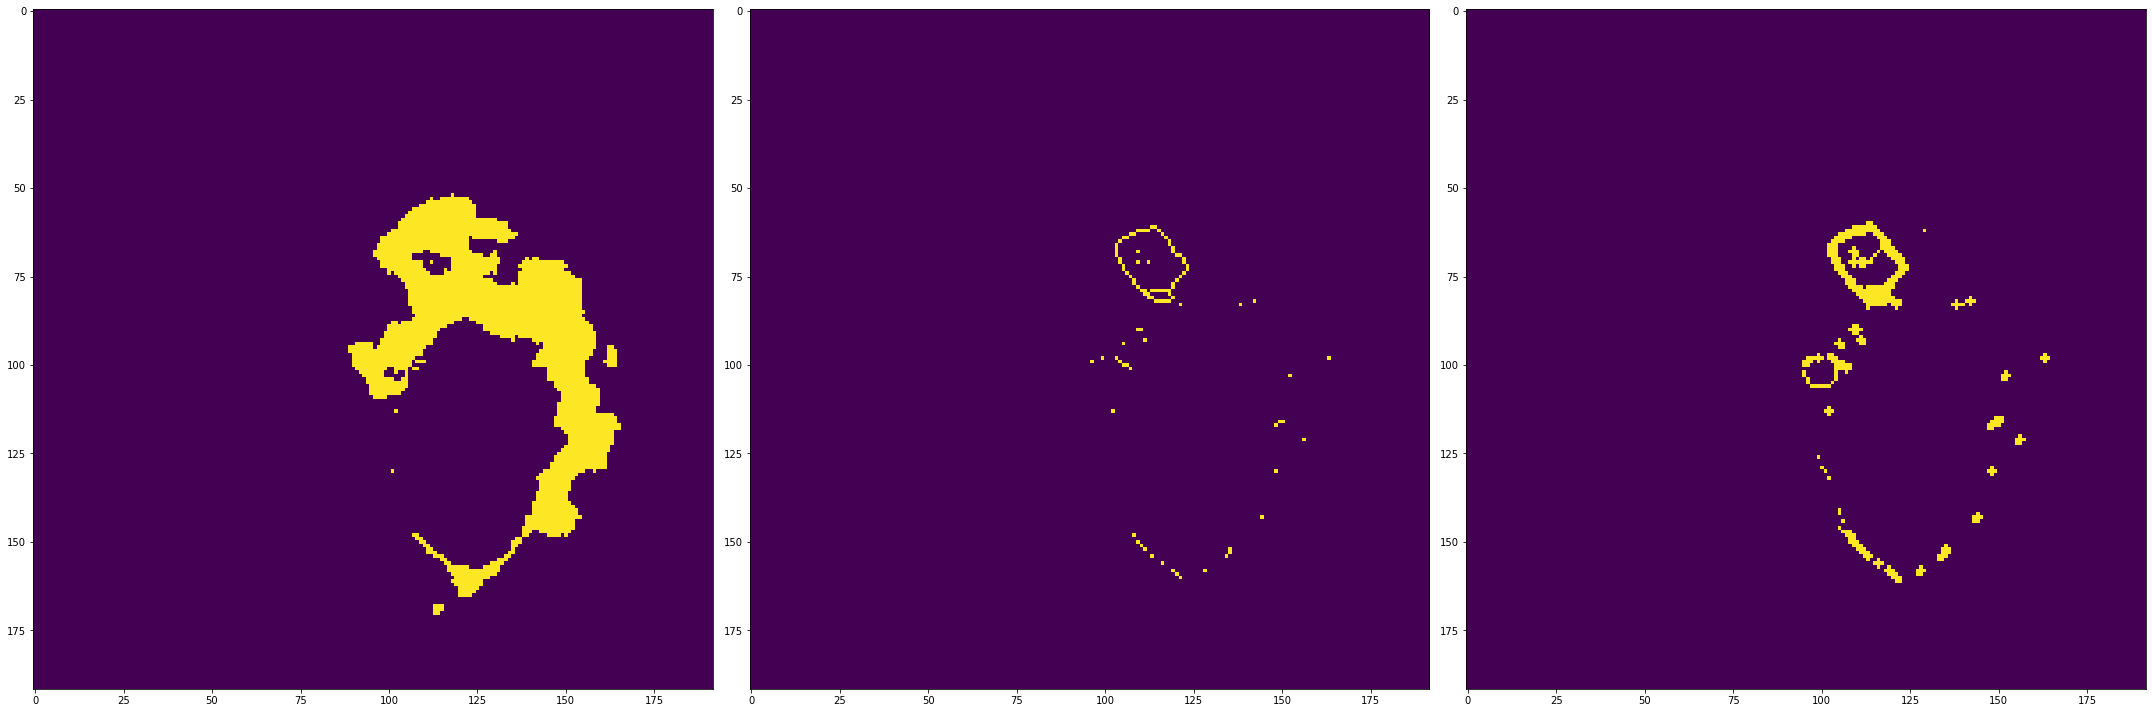

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

ax1, ax2, ax3 = axs.ravel()

ax1.imshow(label_oh_one_class_slice)
ax2.imshow(label_oh_one_class_skeleton_slice)
ax3.imshow(label_oh_one_class_skeleton_dilation_slice)

plt.tight_layout()
plt.show()

##### 策略1： 计算到达骨架的最近距离，归一化，取max(min_dist_label, svls_label)作为最终的label

In [178]:
# 分别得到所有label和skeleton的坐标集合
coords_label = np.array(np.where(label_oh_one_class)).T
coords_skeleton = np.array(np.where(label_oh_one_class_skeleton_dilation)).T

from scipy.spatial.distance import cdist

# 计算点对(内部点和表面点)之间的距离
dist = cdist(coords_label, coords_skeleton, metric='euclidean')  

In [179]:
# 得到每个内部点到表面的最近距离
min_dist = np.min(dist, axis=1)

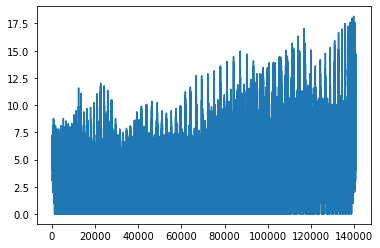

In [180]:
plt.figure()
plt.plot(min_dist.flatten())
plt.show()

In [181]:
# 归一化，限制范围为[0, 1]
min_dist = min_dist / np.max(min_dist)
# 反转
min_dist = 1.0 - min_dist

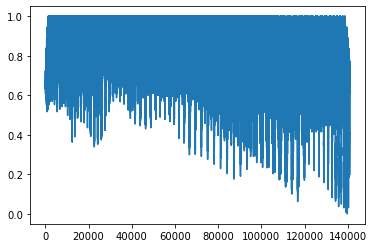

In [182]:
plt.figure()
plt.plot(min_dist.flatten())
plt.show()

In [183]:
# 将最短距离映射回体数据
x, y, z = zip(*coords_label)

min_dist_label = np.zeros_like(label_oh_one_class) * 1.0
min_dist_label[x, y, z] = min_dist

In [184]:
min_dist_label_slice = min_dist_label[depth]

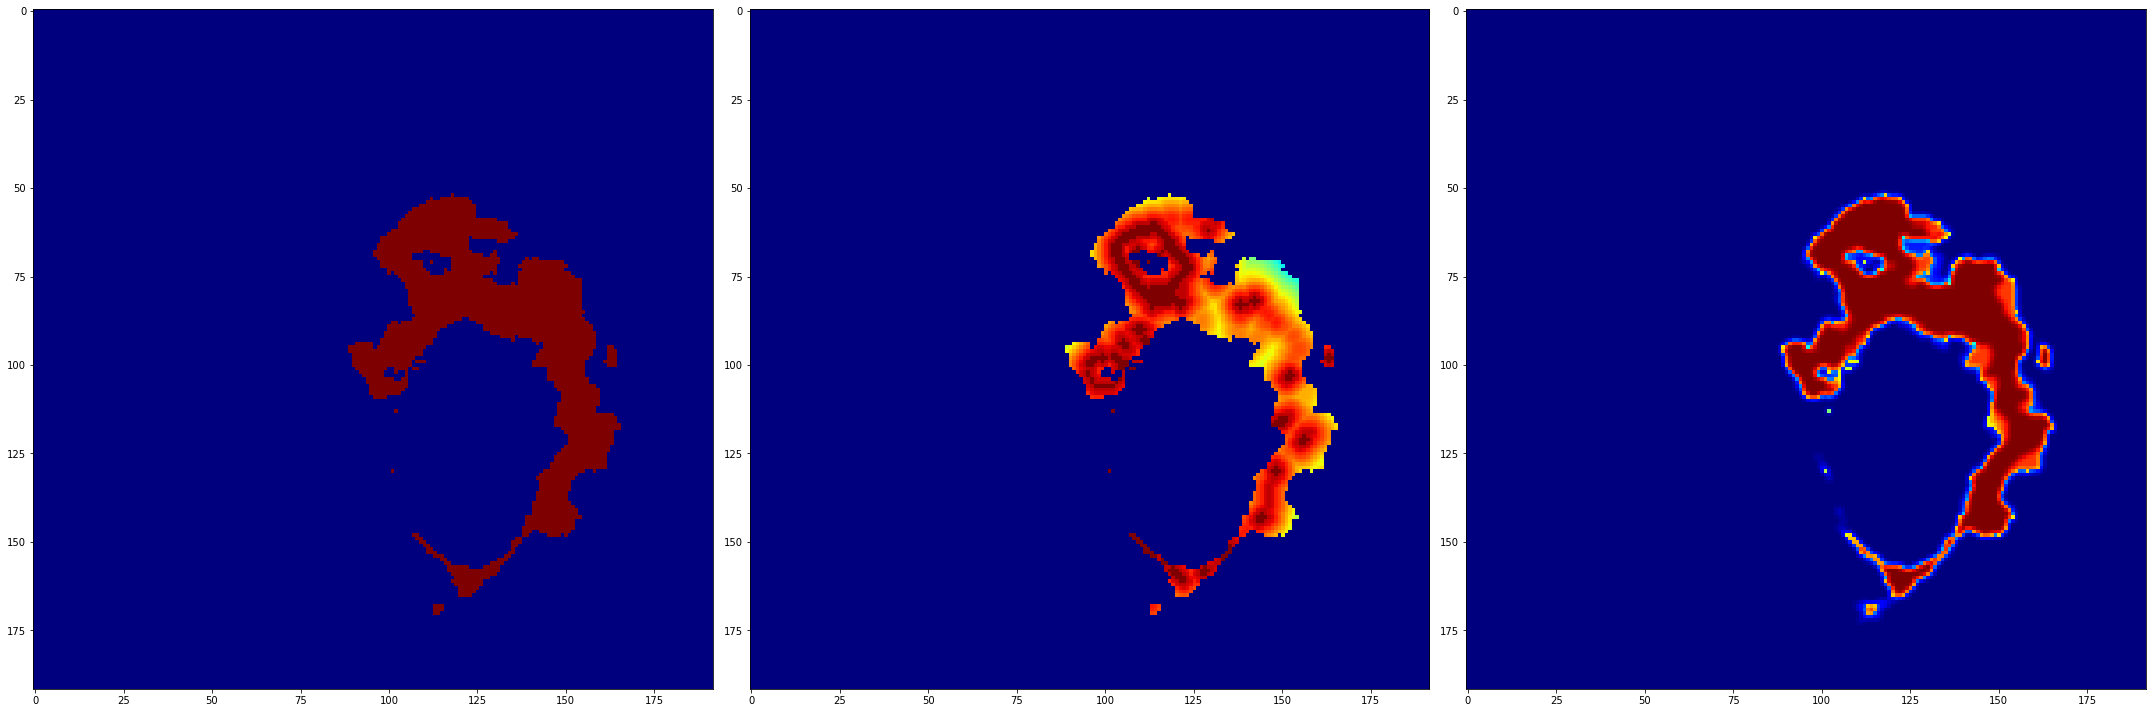

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

ax1, ax2, ax3 = axs

ax1.imshow(label_oh_one_class_slice, cmap='jet')
ax2.imshow(min_dist_label_slice, cmap='jet')
ax3.imshow(label_slice_svls[2], cmap='jet')

plt.tight_layout()
plt.show()

In [80]:
# 绘制三维地形图

# from mpl_toolkits.mplot3d import Axes3D

# x, y = min_dist_label_slice.shape
# X, Y = np.meshgrid(np.arange(x), np.arange(y))

# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig)
# ax.plot_surface(X, Y, min_dist_label_slice, cmap='jet')
# plt.show()

In [186]:
# 合成最终的label

label_svls_one_class = label_svls[0, ...].cpu().numpy()[2]
final_label = np.maximum(min_dist_label, label_svls_one_class)
final_label_slice = final_label[depth]

In [187]:
# 计算差异
diff_slice = final_label_slice - label_slice_svls[2]

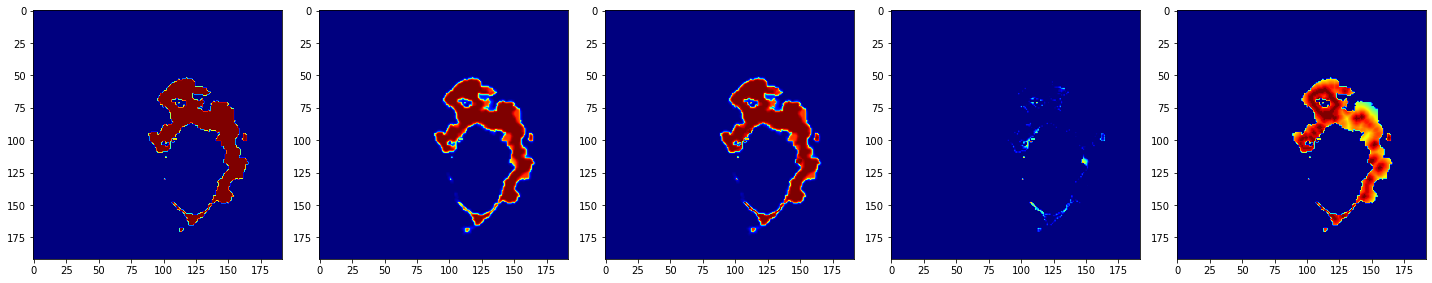

In [188]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

ax1, ax2, ax3, ax4, ax5 = axs.ravel()

ax1.imshow(label_oh_one_class_slice, cmap='jet')
ax2.imshow(label_slice_svls[2], cmap='jet')
ax3.imshow(final_label_slice, cmap='jet')
ax4.imshow(diff_slice, cmap='jet')
ax5.imshow(min_dist_label_slice, cmap='jet')

plt.tight_layout()
plt.show()

##### 策略2: 在骨架的位置使用one_hot_label

In [197]:
# 骨架的位置使用onehot

label_svls_one_class = label_svls[0, ...].cpu().numpy()[2]
final_label = np.where(np.logical_and(
    label_oh_one_class_skeleton_dilation,
    label_oh_one_class
), label_oh_one_class, label_svls_one_class)
final_label_slice = final_label[depth]

In [198]:
# 计算差异
diff_slice = final_label_slice - label_slice_svls[2]

In [199]:
np.min(diff_slice)

0.0

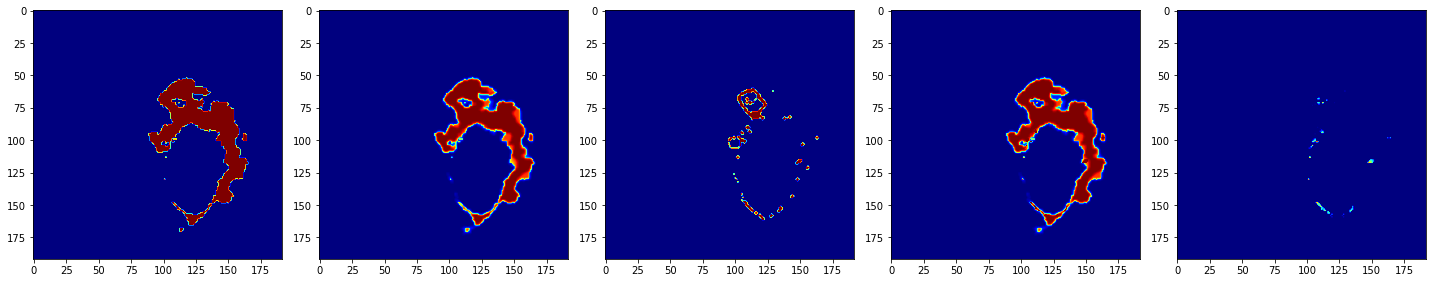

In [200]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

ax1, ax2, ax3, ax4, ax5 = axs.ravel()

ax1.imshow(label_oh_one_class_slice, cmap='jet')
ax2.imshow(label_slice_svls[2], cmap='jet')
ax3.imshow(label_oh_one_class_skeleton_dilation_slice, cmap='jet')
ax4.imshow(final_label_slice, cmap='jet')
ax5.imshow(diff_slice, cmap='jet')

plt.tight_layout()
plt.show()

##### 训练前测试

/home/s2018013343/anaconda3/lib/python3.8/site-packages/skimage/util/dtype.py:541: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)


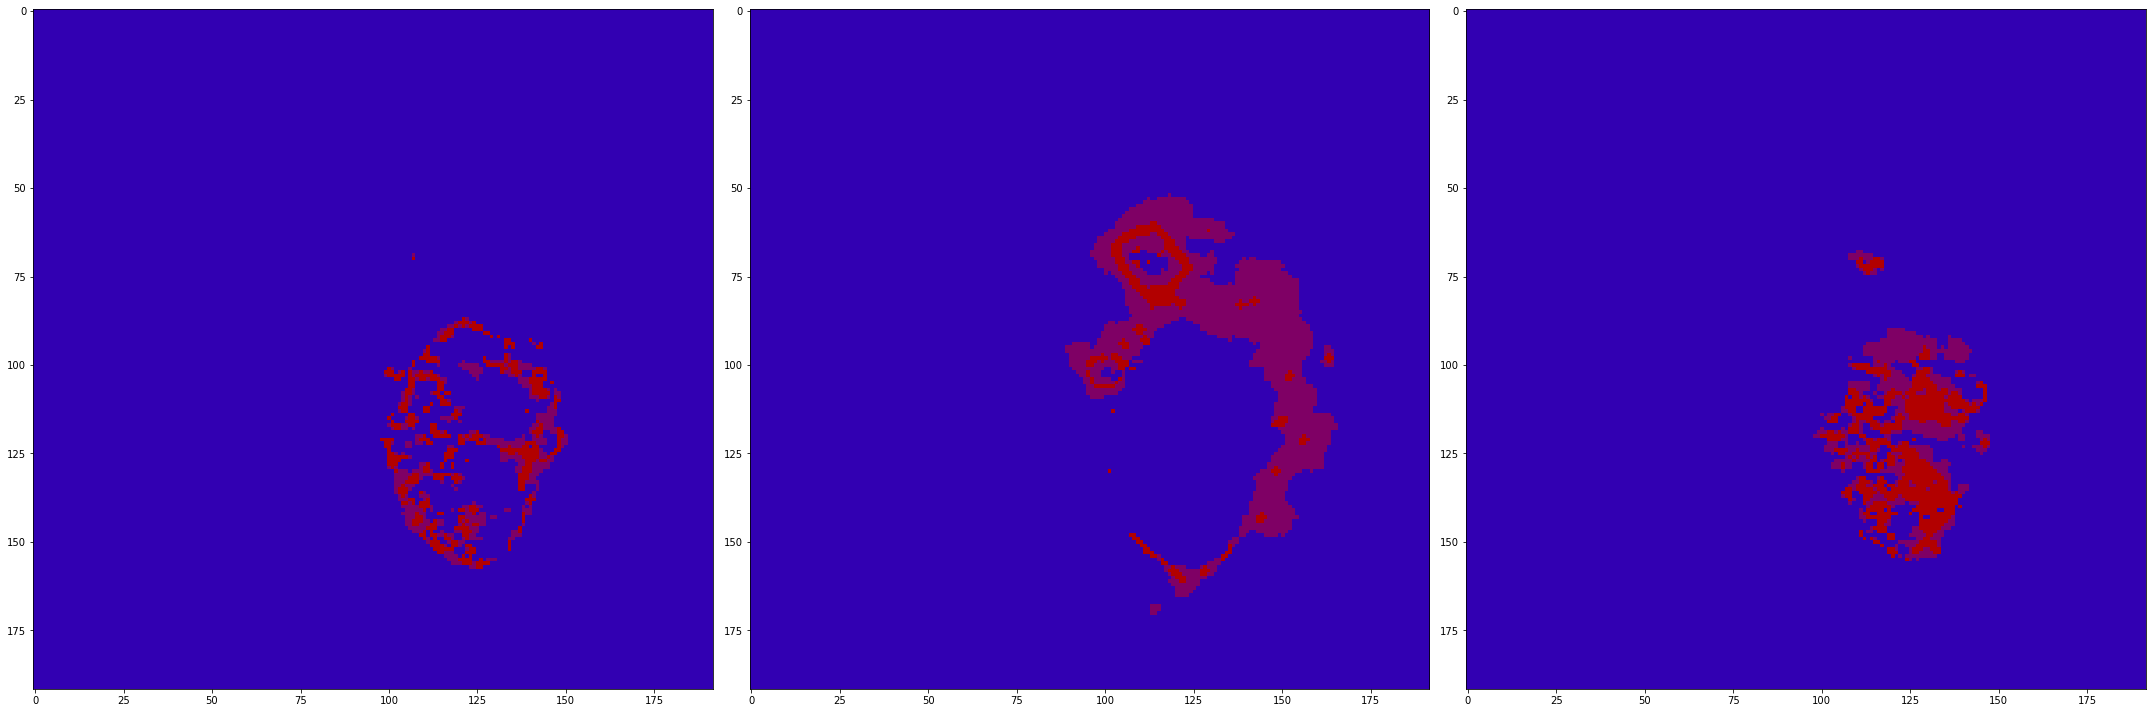

In [30]:
from skimage import morphology

label = item['label'].cpu()
label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))

label_test_skeleton = list()
# sum_label_test_skeleton = torch.zeros(1, 1, 128, 192, 192)

fig, axs = plt.subplots(1, 3, figsize=(30, 20))

axs_ =  axs.ravel()[:3]

for label_one_class_test, ax in zip(label_oh[0][1:], axs_):
    label_one_class_test_ = morphology.skeletonize(label_one_class_test)
    label_one_class_test_ = morphology.dilation(label_one_class_test_, morphology.octahedron(1))
    # sum_label_test_skeleton += label_one_class_test_
    label_one_class_test_ = np.where(label_one_class_test==1, label_one_class_test_, label_one_class_test)
    label_test_skeleton.append(label_one_class_test_)
    ax.imshow(label_one_class_test[depth], cmap='jet')
    ax.imshow(label_one_class_test_[depth], alpha=0.4, cmap='rainbow')

label_test_skeleton = np.stack(label_test_skeleton, axis=0)

plt.tight_layout()
plt.show()

In [32]:
label_test_skeleton.shape

(3, 128, 192, 192)

In [34]:
sum_label_test_skeleton_ = torch.sum(torch.tensor(label_test_skeleton[None, ...]), dim=1, keepdim=True)

final_label = torch.where(
    sum_label_test_skeleton_==1,
    label_oh.float().cpu(), label_svls.cpu())

a = 80
b = 115

print(sum_label_test_skeleton_[0, 0, 60, a, b])
print(label_oh[0, :, 60, a, b])
print(label_svls[0, :, 60, a, b])
print(final_label[0, :, 60, a, b])

tensor(1)
tensor([0, 0, 1, 0])
tensor([0.0000, 0.0000, 1.0000, 0.0000], device='cuda:0')
tensor([0., 0., 1., 0.])


In [35]:
label_one_class_test_.shape

(128, 192, 192)

In [36]:
label_oh[:, :1, ...].shape

torch.Size([1, 1, 128, 192, 192])

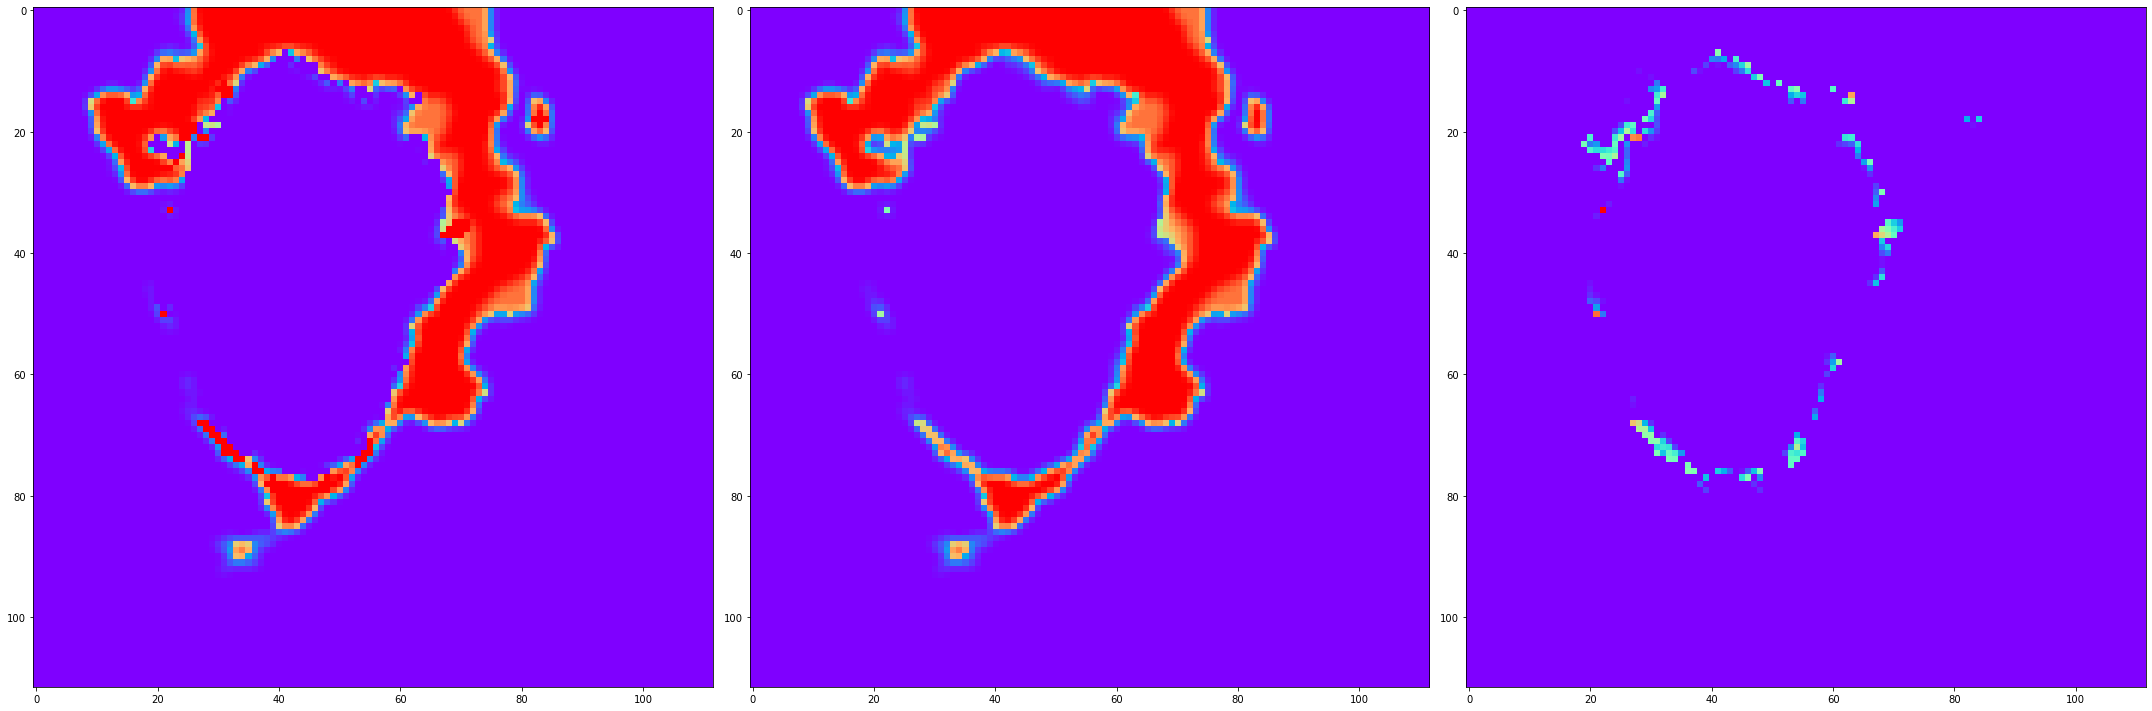

In [37]:
final_label_slice = final_label[0, 2, depth].cpu().numpy()
label_svls_slice = label_svls[0, 2, depth].cpu().numpy()
diff = final_label_slice - label_svls_slice

# diff = (diff - np.min(diff)) / (np.max(diff) - np.min(diff))

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

ax1, ax2, ax3 = axs.ravel()

ax1.imshow(final_label_slice[80:, 80:], cmap='rainbow')
ax2.imshow(label_svls_slice[80:, 80:], cmap='rainbow')
ax3.imshow(abs(diff)[80:, 80:], cmap='rainbow')


plt.tight_layout()
plt.show()


In [125]:
diff[100, 100]

0.0

In [50]:
label.device



# skeleton 实现生成好，作为label中额外的channel

device(type='cpu')

In [62]:
label_test = label.numpy()
label_test.shape



(1, 128, 192, 192)

In [84]:
def one_coding(label, class_num=4):
    """get one-hot coding for labels of a sample"""
    label_oh = np.eye(class_num)[label][0]
    label_oh = np.transpose(label_oh, (3, 0, 1, 2))
    
    return label_oh

def get_dilated_skeleton(label_oh):  # label_oh shape: [class_num, HWD]
    """get dilated skeleton of one-hot coded labels of a given sample"""
    label_dilated_skeleton = list()
    label_dilated_skeleton.append(np.zeros_like(label_oh[0]))  # place holder for the background class (we don't need it)
    for label_oh_ in label_oh[1:]:  # except for the background class
        label_oh_skeleton = morphology.skeletonize(label_oh_)
        label_oh_dilated_skeleton = morphology.dilation(label_oh_skeleton)
        label_oh_dilated_skeleton = np.where(
            label_oh_==1, 
            label_oh_dilated_skeleton, 
            label_oh_) # make sure that the skeleton is within the label map
        label_dilated_skeleton.append(label_oh_dilated_skeleton)
    label_dilated_skeleton = np.stack(label_dilated_skeleton, axis=0)

    return label_dilated_skeleton

In [85]:
label_test_oh = one_coding(label_test)
label_test_skeleton = get_dilated_skeleton(label_test_oh)

In [88]:
label_test_skeleton.shape

(4, 128, 192, 192)

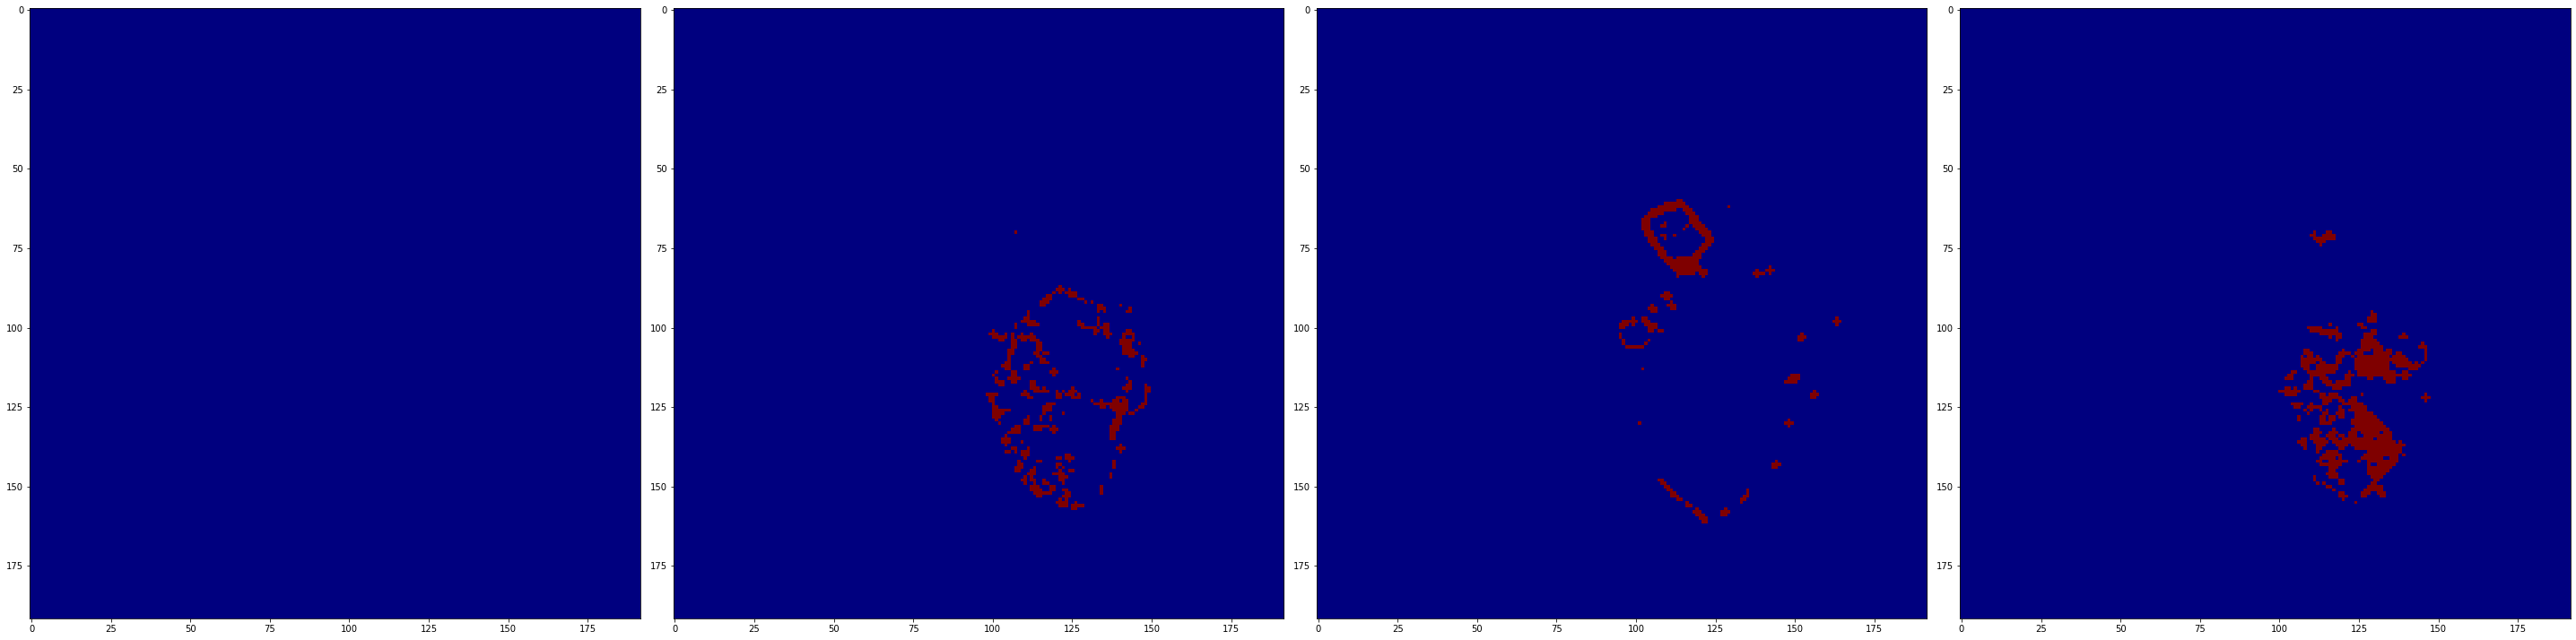

In [75]:
fig, axs = plt.subplots(1, 4, figsize=(40, 10))

ax1, ax2, ax3, ax4 = axs.ravel()

ax1.imshow(label_test_skeleton[0, 0, depth], cmap='jet')
ax2.imshow(label_test_skeleton[0, 1, depth], cmap='jet')
ax3.imshow(label_test_skeleton[0, 2, depth], cmap='jet')
ax4.imshow(label_test_skeleton[0, 3, depth], cmap='jet')

plt.tight_layout()
plt.show()

In [58]:
a = 60
b = 115
c = 150

print(label[0, a, b, c])

print(label_test_oh[0, :, a, b, c])

tensor(2)
[0. 0. 1. 0.]


In [2]:
from datasets import get_datasets_brats_with_skeleton

DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats_with_skeleton(data_root=DATA_PATH)

In [3]:
ls = LS(4, 0.1).cuda()
svls = SVLS(4, 1.0).cuda()

In [13]:
sample_idx = 12
depth = 60

item = train_dataset[sample_idx]
label = item['label'].cuda()
image = item['image'].float().cuda()
skeleton = item['skeleton'].cuda()
print(image.shape)
print(label.shape)
print(skeleton.shape)

label_oh = torch.permute(F.one_hot(label), (0, 4, 1, 2, 3))
label_ls = ls(label)
label_svls = svls(label)

print(label_oh.shape)
print(label_ls.shape)
print(label_svls.shape)

label_slice_oh = label_oh[0, :, depth, ...].cpu().numpy()
label_slice_ls = label_ls[0, :, depth, ...].cpu().numpy()
label_slice_svls = label_svls[0, :, depth, ...].cpu().numpy()

skeleton_slice = skeleton[:, depth, ...].cpu().numpy()

print(label_slice_oh.shape)
print(label_slice_ls.shape)
print(label_slice_svls.shape)
print(skeleton_slice.shape)

image_slice = image[:, depth, ...].cpu().numpy()

torch.Size([4, 128, 192, 192])
torch.Size([1, 128, 192, 192])
torch.Size([4, 128, 192, 192])
torch.Size([1, 4, 128, 192, 192])
torch.Size([1, 4, 128, 192, 192])
torch.Size([1, 4, 128, 192, 192])
(4, 192, 192)
(4, 192, 192)
(4, 192, 192)
(4, 192, 192)


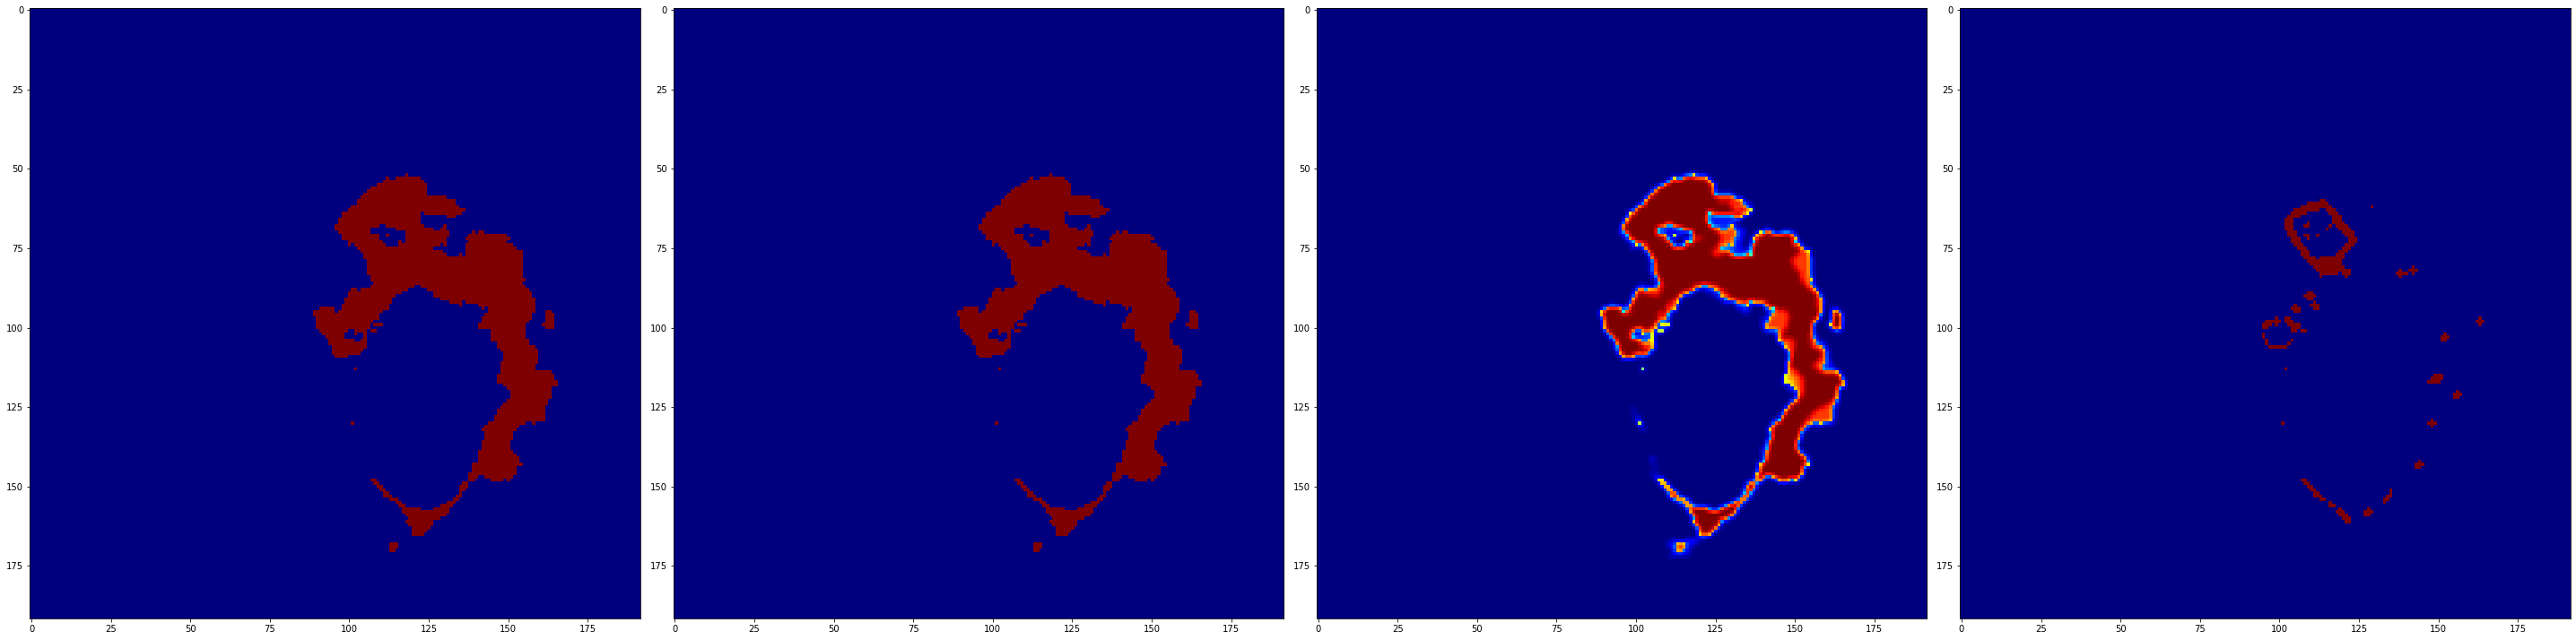

In [12]:
fig, axs = plt.subplots(1, 4,  figsize=(40, 10))

ax1, ax2, ax3, ax4 = axs

ax1.imshow(label_slice_oh[2], cmap='jet')
ax2.imshow(label_slice_ls[2], cmap='jet')
ax3.imshow(label_slice_svls[2], cmap='jet')
ax4.imshow(skeleton_slice[2], cmap='jet')


plt.tight_layout()
plt.show()

##### 测试loss函数

In [13]:
import torch

from svls import CELossWithSVLS_V2, CELossWithSVLS, CELossWithLS
from datasets import get_datasets_brats_with_skeleton

DATA_PATH = '/home/s2018013343/project/exp4_dl/SVLS/MICCAI_BraTS_2019_Data_Training/HGG_LGG'

train_dataset, val_dataset = get_datasets_brats_with_skeleton(data_root=DATA_PATH)

svls = CELossWithSVLS(4, 1.0).cuda()
svls_v2 = CELossWithSVLS_V2(4, 1.0).cuda()
ls = CELossWithLS(4, 0.1).cuda()

sample_idx = 12

item = train_dataset[sample_idx]
label = item['label'].cuda()
skeleton = item['skeleton'].cuda()
image = item['image'].cuda()

"""
shapes:
output of model: [B, C, DHW]
label: [B, DHW]
skeleton: [B, C, DHW]
"""

dummy_input = torch.rand([1, 4, 128, 192, 192], dtype=torch.float32).cuda()

target_svls = svls(dummy_input, label)
target_svls_v2 = svls_v2(dummy_input, label, skeleton[None, ...])
target_ls = ls(dummy_input, label)


False


In [14]:
print(target_svls)
print(target_svls_v2)
print(target_ls)

tensor(1.4173, device='cuda:0')
tensor(1.4173, device='cuda:0')
tensor(1.4173, device='cuda:0')


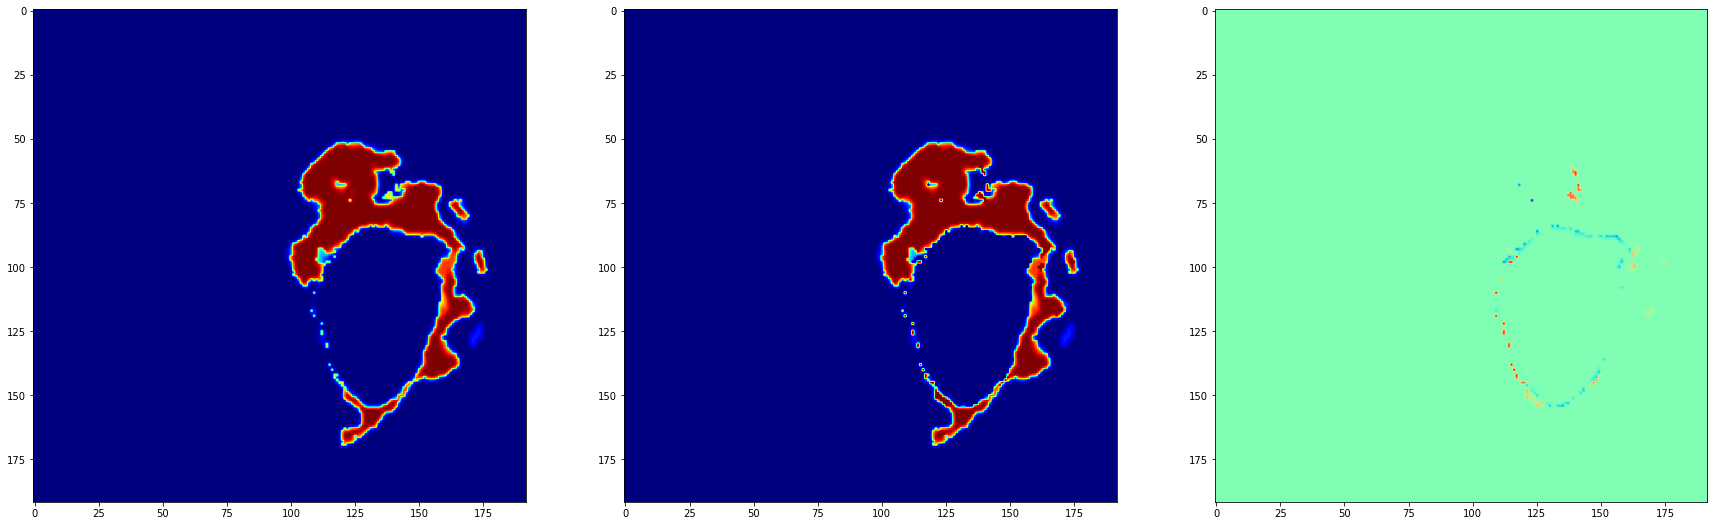

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(30, 10,))

ax1, ax2, ax3 = axs.ravel()

depth = 60

slice_svls_target = target_svls[0, 2, depth].cpu().numpy()
slice_svls_v2_target = target_svls_v2[0, 2, depth].cpu().numpy()
diff = slice_svls_v2_target - slice_svls_target

ax1.imshow(slice_svls_target, cmap='jet')
ax2.imshow(slice_svls_v2_target, cmap='jet')
ax3.imshow(diff, cmap='rainbow')

plt.show()

In [3]:
torch.unique(skeleton)

tensor([  0, 255], device='cuda:0')